**Partie 2**

Cette partie illustre une autre façon d'exploiter des données d'opportunité, non comme des prédicteurs de substitution, mais comme des cibles de substitution.
Par exemple, supposons que:
- on veuille prédire un champ $T$ à partir d'un prédicteur spatialisé (image radar, image satellite,....)
- seuls quelques capteurs ponctuels fiables sont disponibles dans la zone couverte par le prédicteur
- mais une grande quantité de mesures de mauvaise qualité sont disponibles, au moins sur une certaine période. Il peut s'agir, par exemple, de mesures issues de capteurs miniaturisés embarqués sur une flotte de véhicules.

Chercher à utiliser ces mesures "de mauvaise qualité" comme cibles est assez naturel. Mais pour fonder l'approche, il faut caractériser ce défaut de qualité.\
Dans cet exercice, nous supposons que des mesures supplémentaires sont obtenues par des capteurs "non étalonnés" et intermittents. Plus précisément, un capteur non étalonné d'indice $i$ donne au temps $t$ une mesure $\tilde{y}^t_i$ correcte **à une fonction strictement croissante près**, qui est propre au capteur. On le note:
 $$\tilde{y}^t_i = f_i(y^t_i)$$

où $y^t_i$ correspond à la mesure correcte, c'est à dire la mesure qu'on aurait obtenue avec un capteur étalonné; $f_i$ est la fonction strictement croissante, propre au capteur.

Pour montrer que sous cette hypothèse, un apprentissage est envisageable, nous nous donnons de nouveau un jeu d'images de synthèse de tailles 64 x 64. Pour simplifier, nous nous plaçons dans le cas où:
- les images couvrent la même zone physique à des temps différents.
- le prédicteur spatialisé $p^t$ couvre toute la zone.
- Il y a un capteur par pixel. A chaque temps $t$, on produit une image $\tilde{y}^t$ contenant les mesures $\tilde{y}^t_i$.
- il n'y a que deux capteurs étalonnés (dans ce cas $\tilde{y^t_i} = y^t_i$): un au pixel de coordonnées (20,20), l'autre au pixel de coordonnées (40,40). Ceux-là fonctionnent tout le temps.
- les autres capteurs sont non étalonnés. Ils ne fournissent une mesure que 20% du temps.
- enfin, on suppose que les valeurs du prédicteur ne contiennent pas d'information positionnelle : elles ne permettent pas de remonter aux positions des pixels qui les contiennent.


Les cellules suivantes permettent de visualiser le jeu de données.

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

--2024-01-11 15:27:28--  https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679779840 (1.6G) [application/x-tar]
Saving to: ‘L7R8MLxtfzG_NwC5CzNnTSt’

L7R8MLxtfzG_NwC5CzN 100%[===================>]   1.56G  2.53MB/s    in 8m 45s  

2024-01-11 15:36:14 (3.05 MB/s) - ‘L7R8MLxtfzG_NwC5CzNnTSt’ saved [1679779840/1679779840]

data/
data/donut_unet_300ep_step1.pt
data/netG_180ep_WGP_scheduler75_lr005.pt
data/reid_resnet50_60ep.pt
data/tensor_test.pt
data/tensor_test_cpu.pt
data/tensor_train.pt
data/tensor_val.pt
--2024-01-11 15:36:20--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting 

In [3]:
p = 20/100
batch_size = 6
inputs, partial_uncal_measurements = gen_inputs_and_uncal_measurements_train(batch_size, p)


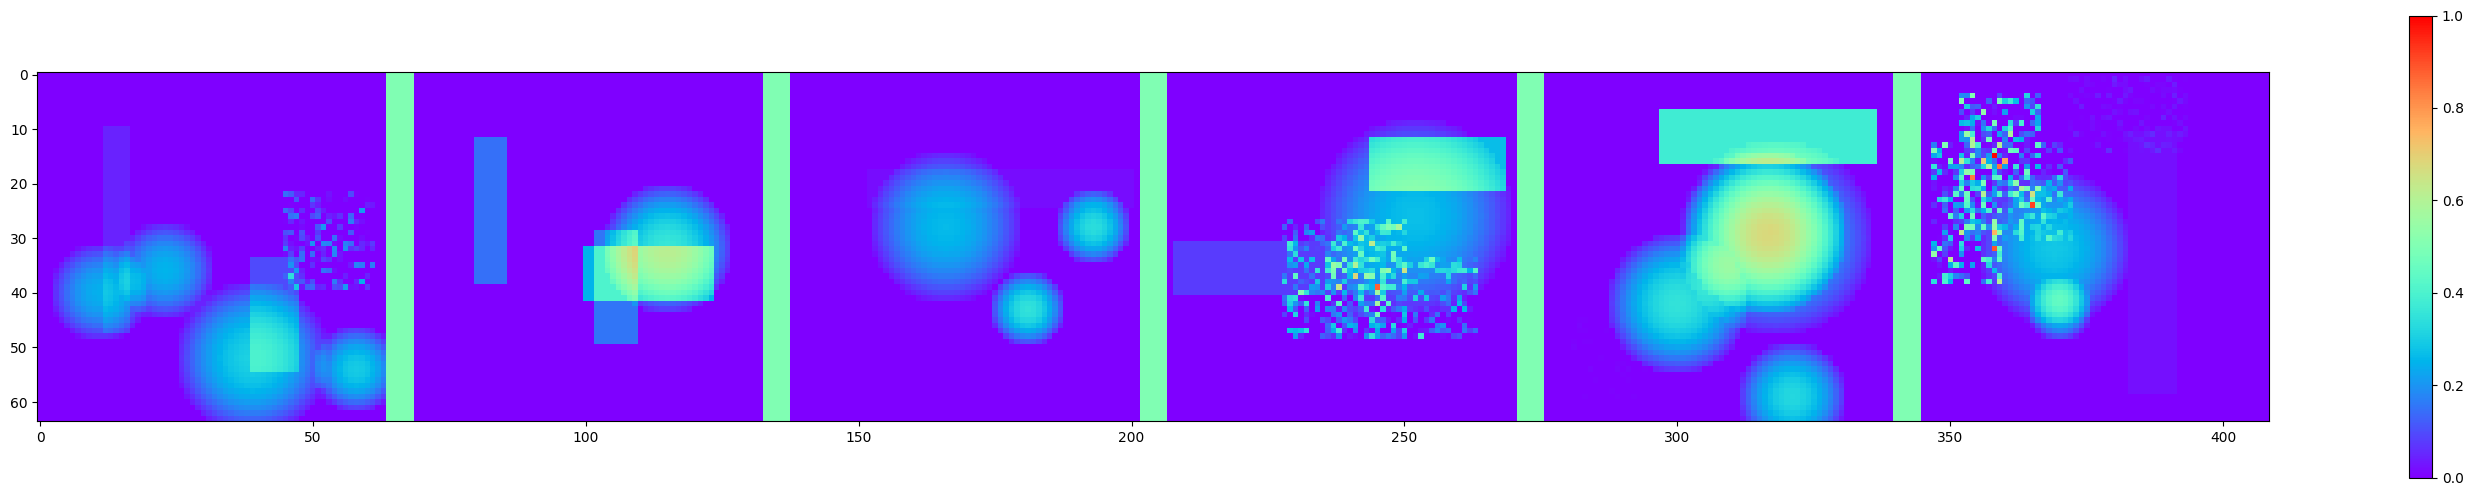

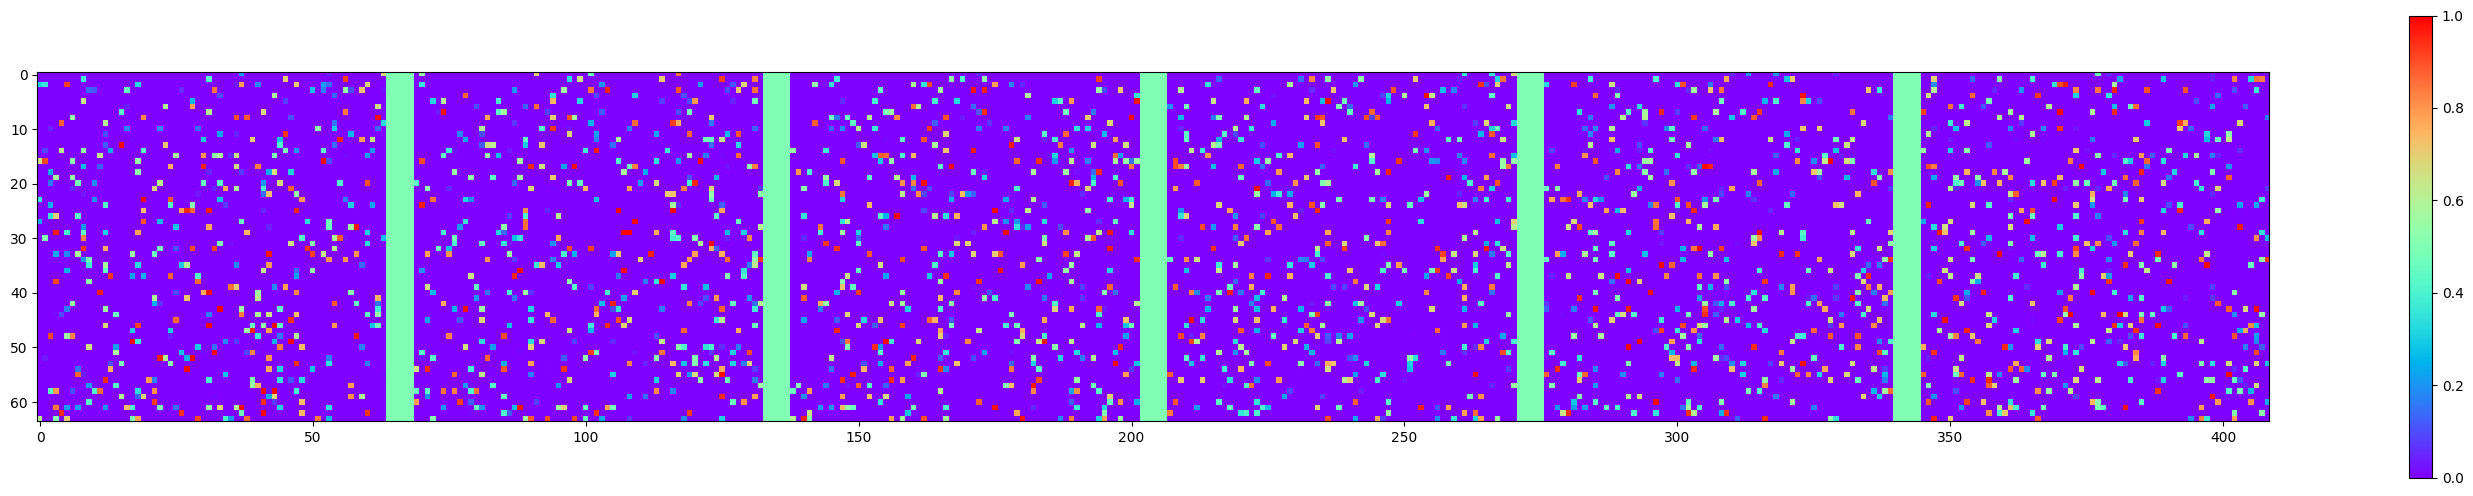

tensor([0.0000, 0.0000, 0.8079, 0.0000, 0.0000, 0.3291])
tensor([0.5627, 0.6979, 0.0000, 0.0000, 0.0000, 0.0000])


In [4]:
# prédicteur spatialisé
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(inputs, 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures issues de capteurs non étalonnés (données d'opportunité)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(partial_uncal_measurements, 6, fig2, k=0, min_scale=0, max_scale=1)

# mesures correctes:
print(partial_uncal_measurements[:,0,20,20])
print(partial_uncal_measurements[:,0,40,40])


La première ligne correspond au prédicteur spatialisé. Il contient des disques et des rectangles.\
La seconde ligne montre des mesures non étalonnées du champ cible (des cibles bruitées). Les valeurs des pixels pour lesquels la mesure est manquante, environ 80%, sont fixées à -100.
Les deux *print* affichent quelques mesures correctes, mais largement insuffisantes pour entraîner un modèle. Remarquer au passage que la mesure correcte est souvent nulle.

Nous allons parvenir à estimer la cible correcte en deux étapes, à partir d'un modèle spécifique (voir **exercice 1**). A la première étape, nous entraînons ce modèle par paires (**exercice 2**), en exploitant le fait que les mesures non-étalonnées conservent l'ordre .
A la seconde étape, nous étalonnons le modèle (**exercice 3**).

**Exercice 1** Description du modèle

**Q1** Le modèle est codé dans la cellule suivante (les objets *Down*, *Up*, etc ont été importés avec *utile_BE*). Il comporte un UNet et un petit réseau complètement connecté. Déterminer la valeur de *n*. Combien de poids le petit réseau contient-il ?

In [5]:
n = 5

class UNet_cal(nn.Module):
    def __init__(self, n_channels, n_classes=1,size=64):
        super(UNet_cal, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.outc2 = outconv(size, n_classes)
        self.n_classes=n_classes


        #Pour la partie étalonnage :
        self.cal1 = nn.Linear(1,5)
        self.cal2 = nn.Linear(5,n)
        self.cal3 = nn.Linear(5,1)
        self.r = nn.ReLU()

    def forward(self, x):
        # Unet
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)

        # Etalonnage:
        z = x.transpose(1, 3)
        z = self.r(self.cal1(z))
        z = self.r(self.cal2(z))
        z = torch.tan(self.cal3(z))
        z = z.transpose(1, 3)

        return   x, z


In [6]:
# Calcul le nombre de poids dans ce UNet

model = UNet_cal(1)
nb_weights = 0
for parameter in model.cal1.parameters():
  nb_weights += torch.numel(parameter)

for parameter in model.cal2.parameters():
    nb_weights += torch.numel(parameter)

for parameter in model.cal3.parameters():
    nb_weights += torch.numel(parameter)

print("Nombre de poids dans le UNet_cal : ", nb_weights)

Nombre de poids dans le UNet_cal :  46


**Q2** Ce modèle renvoie deux sorties. Pour obtenir $z$, on passe le petit réseau complètement connecté sur toutes les composantes de $x$. $x$ correspond à la sortie du UNet. Vérifier que les dimensions des sorties $x$ et $z$ sont bien identiques.


In [7]:
model = UNet_cal(2) # 2 canaux en entrée
y = torch.zeros(1,2,64,64) # 2 canaux en entrée
x, z = model(y)
print("x.shape : ", x.shape)
print("z.shape : ", z.shape)

x.shape :  torch.Size([1, 1, 64, 64])
z.shape :  torch.Size([1, 1, 64, 64])


**Exercice 2**

Dans cet exercice, nous entraînons la partie UNet du modèle sur une tâche de learning to rank. L'idée est de contraindre le réseau à fournir des sorties qui soient arrangées dans le même ordre que les mesures non étalonnées.\
Pour cela nous nous donnons la fonction de coût suivante, où *output0* et *output1* représentent deux sorties $x_0$ et $x_1$ de la partie UNet.

In [8]:
def label_to_sgn(label):
    sgn = 0*label
    eq  = 0*label
    sgn.detach()
    sgn[label==0] = 1
    sgn[label==1] = -1
    eq[label==2] = 1
    return sgn, eq


class MaskedHingeLoss(torch.nn.Module):
    def __init__(self, margin = 0.1):
        super(MaskedHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, output0, output1, label, mask):
        sgn, eq = label_to_sgn(label)
        diff = sgn*(output1 - output0)

        loss_eq = eq*torch.abs(output1 - output0)
        loss = loss_eq + torch.relu(diff + self.margin)

        loss = loss[mask].mean()

        return loss, loss_eq[mask]

**Q1** Quel est le rôle du terme *torch.relu(diff + self.margin)* ?



Le terme torch.relu(diff + self.margin) permet de pénaliser les sorties qui ne sont pas dans le bon ordre que les cibles bruitées (les mesures non étalonnées).

Il y a deux différences évidentes avec la fonction de coût présentée au TP4:
- l'utilisation d'un masque (*mask*). C'est un tenseur de booléens qui indique les positions où les mesures sont présentes sur les deux cibles bruitées (valeur "True").
- le terme "loss_eq". Comme les mesures idéales sont souvent nulles, les mesures issues d'un capteur non étalonné doivent souvent être égales. Le terme "loss_eq" permet justement de tenir compte des cas d'égalité.

**Q2** Pour un batch de 32 paires de cibles bruitées, que doit valoir $torch.sum(mask)$, approximativement ?

Comme la proportion de capteurs qui fonctionnent est d'environ 20%. Ainsi, pour chaque cible bruitée, 20% des pixels sont renseignés.

Sous l'hypothèse que, pour deux images d'une paire, les états de fonctionnement d'un capteur sont indépendants, la proportion de paires de pixels exploitables est de 20% x 20% = 4%.

Pour un batch de 32 paires de cibles bruitées, environ 32 x 64 x 64 x 4% = 524 2 pixels sont exploitables. (car image 64 $\times$ 64)

In [9]:
32*64*64*0.04

5242.88

**Q2**
Quelle fonction de coût particulière est appliquée dans un cas d'égalité ?
Pour quelle valeur de label est-elle appliquée ?

En cas d'égalité, la fonction de coût est la fonction MAE (Mean Absolute Error). Appliquée pour masque = True, elle permet de pénaliser les sorties qui ne sont pas dans le bon ordre que les cibles bruitées (les mesures non étalonnées) et pour label = 0, elle permet de pénaliser les sorties qui ne sont pas égales.

**Q3** Instancier le modèle, l'optimizer et la fonction de coût puis compléter la boucle d'apprentissage.

In [10]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet_cal(ch_in,ch_out,size).cuda()

criterion = MaskedHingeLoss(0.1)
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [11]:
nepochs = 50
nbatches = 100
batchsize = 32

# Où l'on stocke l'écart entre les sorties quand les mesures sont identiques:
train_losses_eq = []
# Où l'on stocke la proportion de paires correctment ordonnées:
train_accs = []

fcn.train()
phase = 'train'
for epoch in range(nepochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, nepochs - 1))

    # Pour calculer la loss_eq moyenne sur l'époque
    running_summask = 0.0
    running_loss_eq = 0.0

    # Pour calculer la prop. de paires correctement ordonnées sur l'époque
    running_strict_comparisons = 0
    running_corrects = 0

    # Itération :
    for i in range(nbatches):
        # La paire d'inputs, la paires de cibles bruitées:
        img0, partial_uncal_measurements0 = gen_inputs_and_uncal_measurements_train(batchsize, p)
        img1, partial_uncal_measurements1 = gen_inputs_and_uncal_measurements_train(batchsize, p)

        # Passage sur carte GPU:
        img0 = img0.cuda()
        img1 = img1.cuda()
        pum0 = partial_uncal_measurements0.cuda()
        pum1 = partial_uncal_measurements1.cuda()

        # Définition des labels (valeurs 0, 1 et 2):
        labels = (pum0 < pum1).detach()
        labels = labels.to(torch.float32)
        labels[pum0 == pum1] = 2 # égalité

        # Définition du masque
        mask = (pum0 > -100)*(pum1 > -100)
        mask = mask.detach()

        # Définition d'un masque auxiliaire pour la prop de paires
        # correctement ordonnées :
        mask_foracc = (pum0 > -100)*(pum1 > -100)*(pum0!=pum1)
        mask_foracc = mask_foracc.detach()

        # Mise à zéro des gradients
        optimizer.zero_grad()

        # Réseaux siamois (on ne prend que la première sortie)
        output0, _ = fcn(img0)
        output1, _ = fcn(img1)

        # prédictions
        _, preds = torch.max(torch.cat((output0, output1), dim=1), 1)

        # Application de la fonction de coût
        loss, loss_eq = criterion(output0, output1, labels, mask)

        # Rétropropagation
        loss.backward()
        optimizer.step()

        # Stats
        loss_eq = loss_eq.detach()
        nb_eq = torch.sum(loss_eq.detach() != 0).to(torch.float)

        summask = torch.sum(mask).to(torch.float)
        running_summask += nb_eq/10000.
        running_loss_eq += loss_eq.mean().item() * nb_eq/10000.

        nb_strict_comparisons = torch.sum(mask_foracc).to(torch.float)
        running_strict_comparisons += nb_strict_comparisons
        corrects = (preds.unsqueeze(dim=1) == labels.to(torch.long))[mask_foracc]
        running_corrects += torch.sum(corrects)

        del loss
        del loss_eq
        del img0
        del img1
        del pum0
        del pum1
        del labels
        del output0
        del output1
        torch.cuda.empty_cache()



    train_loss = running_loss_eq / running_summask
    train_acc = running_corrects.double() / running_strict_comparisons

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        phase, train_loss, train_acc))

    train_accs.append(train_acc)
    train_losses_eq.append(train_loss)



----------
Epoch 0/49
train Loss: 0.0389 Acc: 0.6541
----------
Epoch 1/49
train Loss: 0.0064 Acc: 0.6861
----------
Epoch 2/49
train Loss: 0.0049 Acc: 0.6968
----------
Epoch 3/49
train Loss: 0.0050 Acc: 0.7333
----------
Epoch 4/49
train Loss: 0.0056 Acc: 0.8412
----------
Epoch 5/49
train Loss: 0.0045 Acc: 0.8700
----------
Epoch 6/49
train Loss: 0.0034 Acc: 0.8961
----------
Epoch 7/49
train Loss: 0.0026 Acc: 0.8996
----------
Epoch 8/49
train Loss: 0.0023 Acc: 0.9071
----------
Epoch 9/49
train Loss: 0.0021 Acc: 0.9111
----------
Epoch 10/49
train Loss: 0.0021 Acc: 0.9200
----------
Epoch 11/49
train Loss: 0.0019 Acc: 0.9255
----------
Epoch 12/49
train Loss: 0.0020 Acc: 0.9272
----------
Epoch 13/49
train Loss: 0.0018 Acc: 0.9301
----------
Epoch 14/49
train Loss: 0.0018 Acc: 0.9350
----------
Epoch 15/49
train Loss: 0.0018 Acc: 0.9415
----------
Epoch 16/49
train Loss: 0.0016 Acc: 0.9400
----------
Epoch 17/49
train Loss: 0.0017 Acc: 0.9389
----------
Epoch 18/49
train Loss: 0.0

**Q4** Visualiser les sorties de la partie UNet après l'apprentissage. Si tout s'est bien passé, la véritable structure de la cible apparaît.

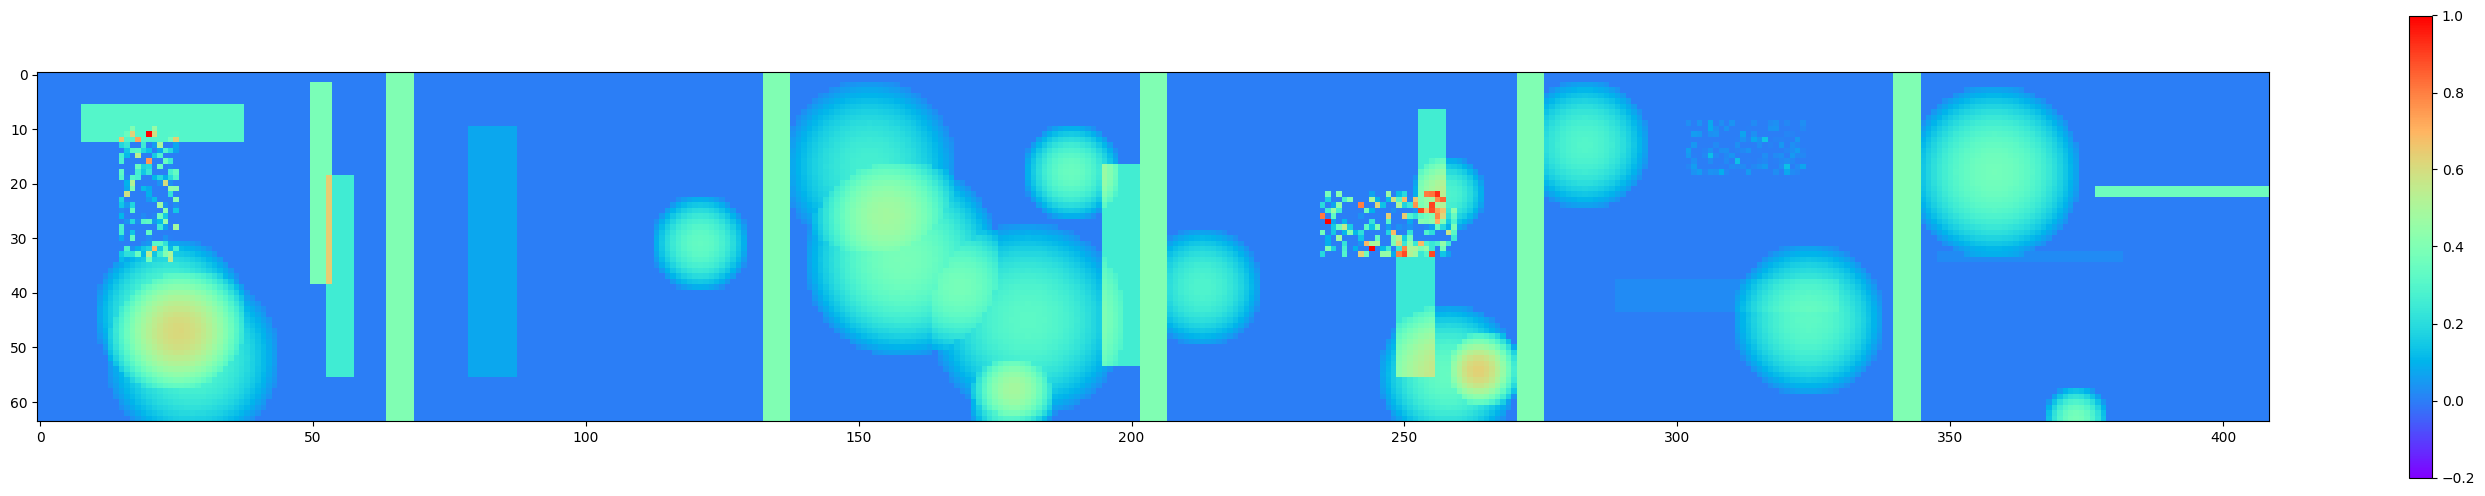

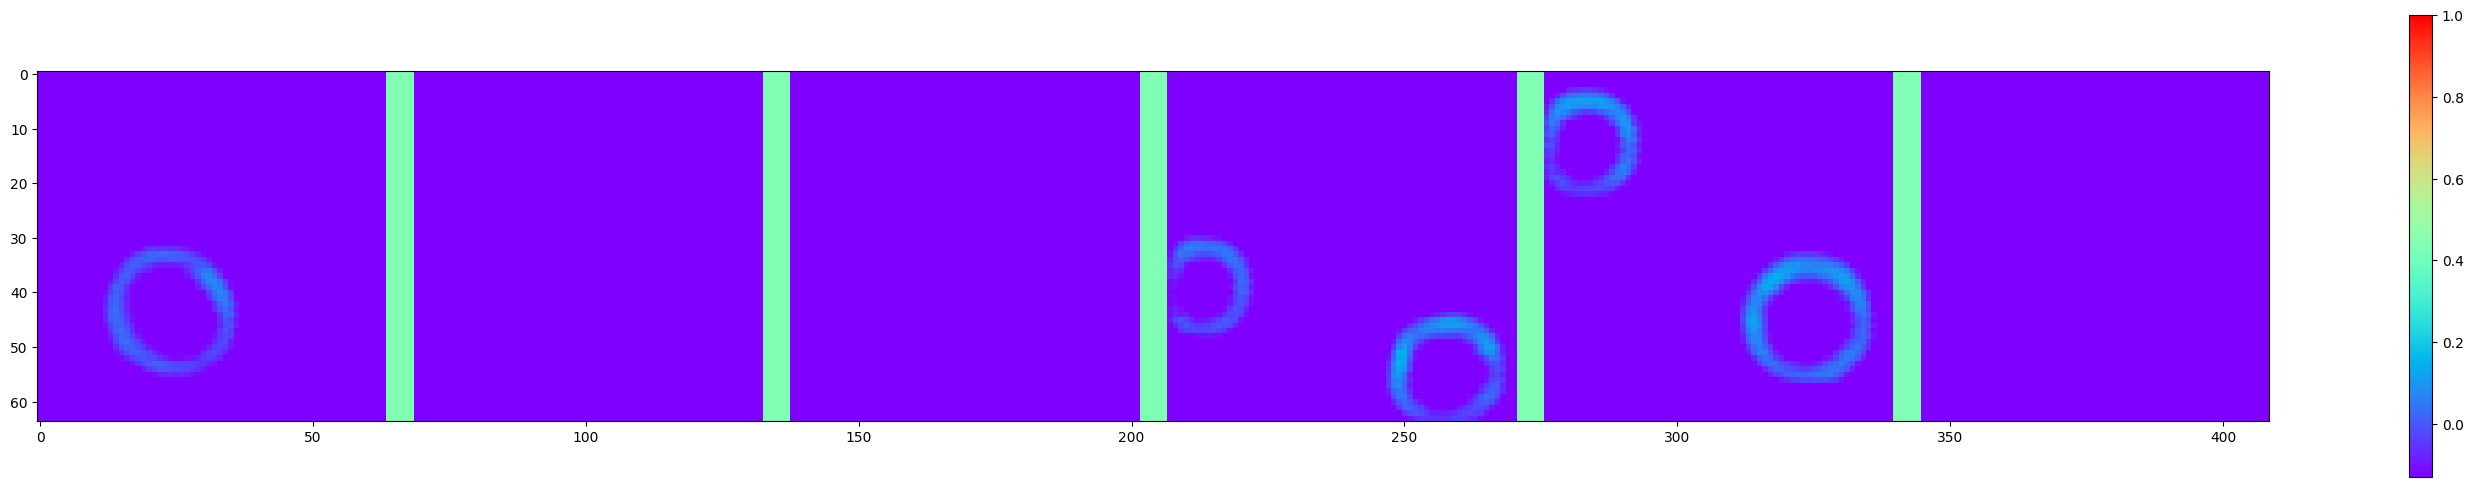

In [12]:
fcn.eval()
batchsize_test = 6
img1, corrected_target, partial_uncal_measurements1 , _, _ = gen_inputs_and_uncal_measurements(batchsize_test)
img1 = img1.cuda()
output, _ = fcn(img1)
output = output.detach().cpu()

fig4 = plt.figure(4, figsize=(36, 6))  #première lignes: entrées
voir_batch2D(img1.cpu(), 6, fig4, k=0, min_scale=-0.2, max_scale=1)

fig6 = plt.figure(6, figsize=(36, 6))  #dernière ligne: sorties
voir_batch2D(output, 6, fig6, k=0, min_scale=-0.13,max_scale=1.)


**Q5** Pour affiner le résultat, il suffit de faire tourner l'apprentissage plus longtemps. Charger le fichier *'donut_unet_300ep_step1.pt'* récupéré sur wetransfer. Il correspond aux poids d'un *UNet_cal* entraîné sur 300 époques avec un batch de taille 128.

In [14]:
ch_in = 1
ch_out = 1
size = 8

fcn = UNet_cal(ch_in,ch_out,size).cuda()

model_name = './data/donut_unet_300ep_step1.pt'
PATH = model_name
weights = torch.load(PATH)

fcn.load_state_dict(weights)

<All keys matched successfully>

**Q6** La fonction *gen_inputs_and_uncal_measurements_test* permet de visualiser une cible parfaite (mesures correctes). Comparer avec la sortie du UNet précédent et commenter brièvement.

In [21]:
batchsize_test = 6
img1, full_target, partial_uncal_measurements = gen_inputs_and_uncal_measurements_test(batchsize_test)

img1 = img1.cuda()
output, _ = fcn(img1)
output = output.detach().cpu()

# prédicteur spatialisé
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(img1.cpu(), 6, fig1, k=0, min_scale=0, max_scale=1)

# mesures issues de capteurs non étalonnés (données d'opportunité)
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(full_target, 6, fig2, k=0, min_scale=0, max_scale=1)

# mesures issues de capteurs non étalonnées (données d'oportunité)
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=0, max_scale=1)

NameError: name 'corrects_targets' is not defined

**Q7** Expliquer en quoi le choix d'un FCN est essentiel ici. En particulier, dire sur laquelle de nos hypothèses ce choix s'appuie.

Le choix d'un FCN est essentiel ici parce que, en effet, pour minimiser la MaskedHingeLoss le FCN doit fournir, pour chaque pixel i, une valeur $f_i(y_i^t)$ où $f_i$ est une fonction strictement croissante.

Or, la prédiction d'un FCN au pixel $i$ qui s'effectue par convolutions successives, ne peut dépendre que du champ de valeurs autour de ce pixel.

Comme la position $i$ n'est pas encodée dans le champ de valeur (dernière hyp., qui dit qu'on suppose que les valeurs du prédicteur ne continnent pas d'information positionnelle : elles ne permettent pas de remonter aux positions des pixels qui les contenaient), le réseau peut répondre à la contrainte qu'avec une fonction $f$ unique, indépendante de $i$.

Avec un réseau complètement connecté, le traitement peut être spécifique à la position du pixel, et rien oblige à n'utiliser qu'une seule fonction.

**Exercice 3**


Dans cette partie, il s'agit d'étalonner la prédiction. C'est là que le petit réseau complètement connecté entre en jeu.

**Q1** Geler (freezing - voir TP1) toutes les couches de la partie UNet. Les poids de cette partie ne doivent plus être modifiés.

In [ ]:
for module in fcn.modules():
    if isinstance(module, nn.Conv2d)\
        or isinstance(module, nn.BatchNorm2d)\
        or isinstance(module, nn.ConvTranspose2d):
        for param in module.parameters():
            param.requires_grad = False

In [ ]:
# Réinitialiser les poids du petit modèle
for module in fcn.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)

**Q2** Entraîner le modèle sur les données du capteur étalonné en position (20,20). Valider sur les données du capteur en position (40,40) pour vérifier que la position n'est pas apprise.

**Q3** Comparer (qualitatif) la sortie finale à la sortie idéale et conclure.